In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display
from util import fft_frequencies
import mappings
import pickle
import PIL
import IPython.display

In [2]:
import detect_musical_regions

### Teste do parâmetro K

In [3]:
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)

In [4]:
spec = np.abs(librosa.stft(y, n_fft=2048))

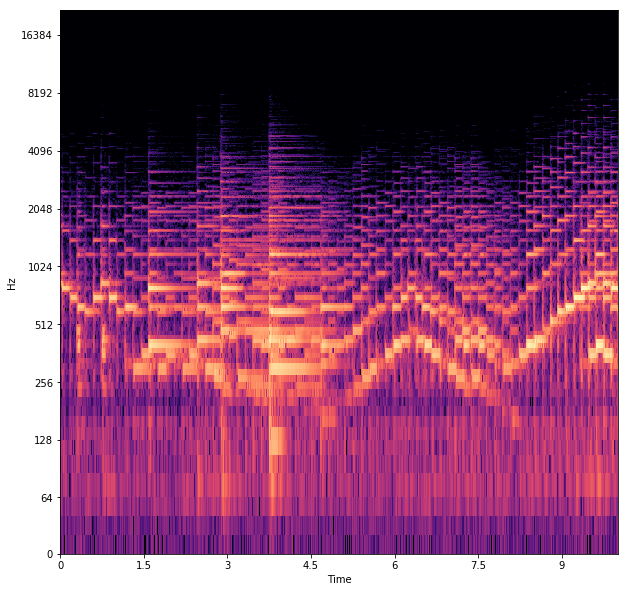

In [5]:
plt.figure(figsize=[10,10])
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=44100,  hop_length=512, y_axis='log', x_axis='time')

In [6]:
time_range = [1.2,3]
freq_range = [250, 300]

In [12]:
n_fft = 2048
D_zoom, x_axis, y_axis, new_sr, new_window_size, new_hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)

ring mod + lpf


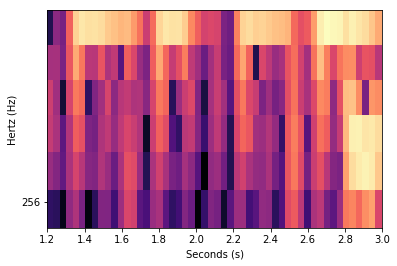

In [13]:
display.specshow(librosa.amplitude_to_db(D_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

### Teste do algoritmo em níveis

In [3]:
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

In [4]:
n_fft=2048
kernel=[800,800]
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)
spec = np.abs(librosa.stft(y, n_fft=n_fft))
time_span = [0,len(y)/sr]

In [5]:
singleres_spec = spec

In [6]:
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 

indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, mode='threshold', pct_or_threshold=0.8)
indices = [indices[0]]

# freq_ranges, time_ranges = detect_musical_regions.kernel_to_ranges(time_span, x_size)
to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel)

In [7]:
to_be_refined[0]

([258.3984375, 430.6640625], [3.2055749128919859, 4.006968641114983])

In [8]:
# Depois nos preocupamos com a estrutura de dados. Por enquanto, enfileirar todas as matrizes em uma lista e pronto.
refined_subregions = []

for subregion in to_be_refined:

    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)
    refined_subregions.append([spec_zoom, x_axis, y_axis, time_range, freq_range, new_sr, window_size, hop_size])

ring mod + lpf


In [14]:
spec_img = PIL.Image.fromarray(spec).resize((spec.shape[1], 2049))
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, [2049, spec.shape[1]])

for subregion in refined_subregions[:]:
    t_r = subregion[3]
    f_r = subregion[4]
    spec_img = detect_musical_regions.insert_zoom(spec_img, subregion[0], t_r, f_r, x_axis, y_axis)
    
multires_spec = np.asarray(spec_img)

In [10]:
multires_spec.shape

(2049, 862)

In [13]:
f_r

[258.3984375, 430.6640625]

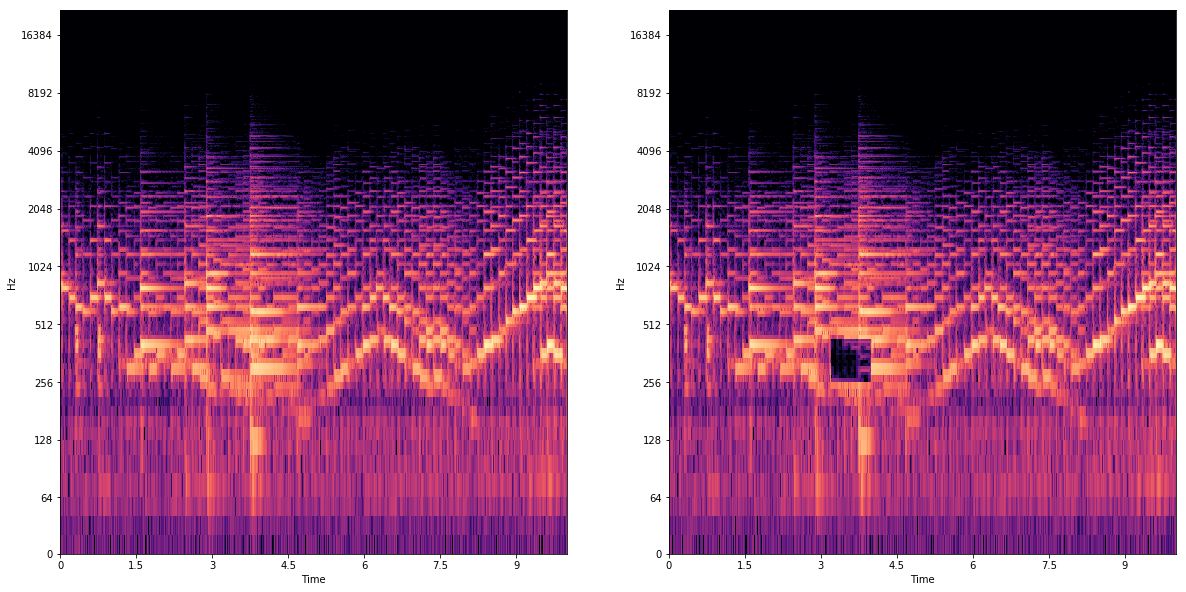

In [15]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

### Agora, 2 níveis

In [41]:
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))
n_fft=2048
kernel=[800,800]
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)
spec = np.abs(librosa.stft(y, n_fft=n_fft))
time_span = [0,len(y)/sr]

In [42]:
singleres_spec = spec

In [43]:
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 

indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, mode='threshold', pct_or_threshold=0.8)
indices = [indices[0]]

# freq_ranges, time_ranges = detect_musical_regions.kernel_to_ranges(time_span, x_size)
to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel)

[0, 1, 2, 4, 7, 12, 20, 32, 51, 81, 129, 205, 326, 518, 823]
[0, 1, 2, 4, 7, 12, 20, 32, 51, 81, 129, 205, 326, 518, 823]
(14, 12)
(168, 2)


In [44]:
to_be_refined

[([258.3984375, 430.6640625], [3.2055749128919859, 4.006968641114983])]

In [45]:
refined_subregions = []

for subregion in to_be_refined:

    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)
    refined_subregions.append([spec_zoom, x_axis, y_axis, time_range, freq_range, new_sr, window_size, hop_size])

ring mod + lpf


In [54]:
# Fazer detecção de subsubregiões interessantes em cada subregião interessante (mas depois generalizar para que
# possamos passar o número de níveis como parâmetro...):

kernel = [200, 200]

for subregion in refined_subregions[:1]:
    spec_zoom   = subregion[0]
    
    # PROBLEMA: NÃO ESTAMOS CORTANDO O EIXO Y - "BORDAS" DE SEGURANÇA ESTÃO FAZENDO PARTE DA DETECÇÃO DE REGIOES INTERESSANTES
    
    x_axis      = subregion[1]
    y_axis      = subregion[2]
    sr          = subregion[5]
    window_size = subregion[6]
    hop_size    = subregion[7]
    
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec_zoom, mode='threshold', pct_or_threshold=0.1, kernel=kernel, n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
    to_be_further_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, sr=sr, hop_size=hop_size)

[0, 5, 11, 17]
[0, 5, 11, 17]
(3, 4)
(12, 2)


In [56]:
to_be_further_refined[1]

([339.6114552514793, 383.10257951183428],
 [3.6236933797909412, 3.8327526132404186])

In [59]:
# Depois nos preocupamos com a estrutura de dados. Por enquanto, enfileirar todas as matrizes em uma lista e pronto.
refined_refined_subregions = []
k=6
sr=44100
hop_size=512
n_fft=2048

for subregion in to_be_further_refined[:3]:

    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=6)
    refined_refined_subregions.append([spec_zoom, x_axis, y_axis, time_range, freq_range, new_sr, window_size, hop_size])

ring mod + lpf
ring mod + lpf
ring mod + lpf


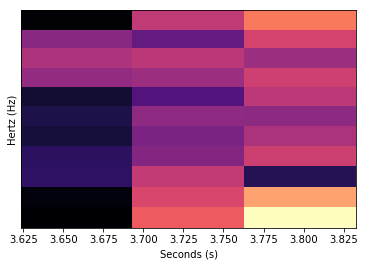

In [60]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

In [66]:
# Aqui, fazer na mão o que seria feito caminhando pela estrutura de dados

spec_img = PIL.Image.fromarray(singleres_spec).resize((spec.shape[1], 4097))

for subregion in refined_subregions[:1]:
    spec_zoom = subregion[0]
    spec_zoom_img = PIL.Image.fromarray(spec_zoom).resize((spec_zoom.shape[1], spec_zoom.shape[0]*2))
    x_axis = subregion[1]
    y_axis = subregion[2] # atenção aqui: como demos resize na imagem, o y_axis muda
    y_axis_new = np.linspace(y_axis[0], y_axis[-1], spec_zoom.shape[0]*2)
    
    for subsubregion in refined_refined_subregions[:]:
        t_r = subsubregion[3]
        f_r = subsubregion[4]
        print(t_r, f_r)
        spec_zoom_img = detect_musical_regions.insert_zoom(spec_zoom_img, subsubregion[0], t_r, f_r, x_axis, y_axis_new)
        

multires_spec = np.asarray(spec_zoom_img)

[3.6236933797909412, 3.8327526132404186] [259.87772744082838, 296.12033099112426]
[3.6236933797909412, 3.8327526132404186] [339.6114552514793, 383.10257951183428]
[3.6236933797909412, 3.8327526132404186] [296.12033099112426, 339.6114552514793]


In [62]:
f_r

[296.12033099112426, 339.6114552514793]

In [63]:
y_axis

array([ 259.87772744,  267.12624815,  274.37476886,  281.62328957,
        288.87181028,  296.12033099,  303.3688517 ,  310.61737241,
        317.86589312,  325.11441383,  332.36293454,  339.61145525,
        346.85997596,  354.10849667,  361.35701738,  368.60553809,
        375.8540588 ,  383.10257951,  390.35110022,  397.59962093,
        404.84814164,  412.09666235,  419.34518306,  426.59370377])

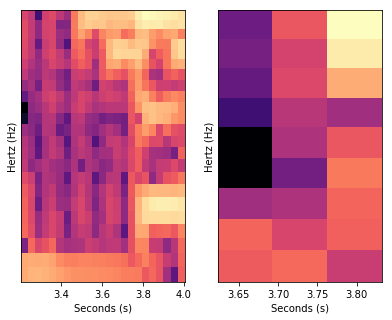

In [64]:
plt.figure(figsize=[10,5])

spec_zoom = refined_subregions[0][0]
x_axis = refined_subregions[0][1]
y_axis = refined_subregions[0][2]

plt.subplot(1,3,1)
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

spec_zoom = refined_refined_subregions[0][0]
x_axis = refined_refined_subregions[0][1]
y_axis = refined_refined_subregions[0][2]

plt.subplot(1,3,2)
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

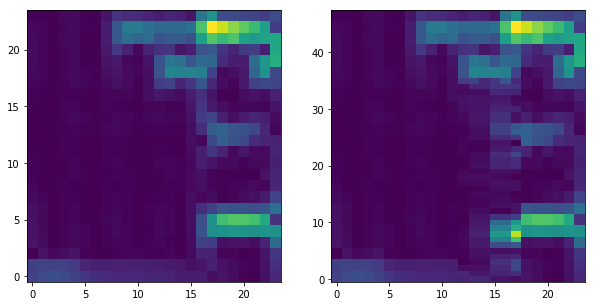

In [65]:
plt.figure(figsize=[10,5])
spec_zoom = refined_subregions[0][0]
x_axis = refined_subregions[0][1]
y_axis = refined_subregions[0][2]

plt.subplot(1,2,1)
plt.imshow(spec_zoom, aspect='auto', origin='lower')

plt.subplot(1,2,2)
plt.imshow(multires_spec, aspect='auto', origin='lower')

In [37]:
# Aqui, fazer na mão o que seria feito caminhando pela estrutura de dados

spec_img = PIL.Image.fromarray(singleres_spec).resize((spec.shape[1], 4097))

for subregion in refined_subregions[:1]:
    spec_zoom = subregion[0]
    spec_zoom_img = PIL.Image.fromarray(spec_zoom).resize((spec_zoom.shape[1], spec_zoom.shape[0]*2))
    x_axis = subregion[1]
    y_axis = subregion[2] # atenção aqui: como demos resize na imagem, o y_axis muda
    y_axis_new = np.linspace(y_axis[0], y_axis[-1], spec_zoom.shape[0]*2)
    
    for subsubregion in refined_refined_subregions[:1]:
        t_r = subsubregion[3]
        f_r = subsubregion[4]
        spec_zoom_img = detect_musical_regions.insert_zoom(spec_zoom_img, subsubregion[0], t_r, f_r, x_axis, y_axis_new)
        
    
    multires_zoom = np.asarray(spec_zoom_img)
    
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, [4097, spec.shape[1]])
    t_r = subregion[3]
    f_r = subregion[4]
    spec_img = detect_musical_regions.insert_zoom(spec_img, np.asarray(multires_zoom), t_r, f_r, x_axis, y_axis)
    
multires_spec = np.asarray(spec_img)

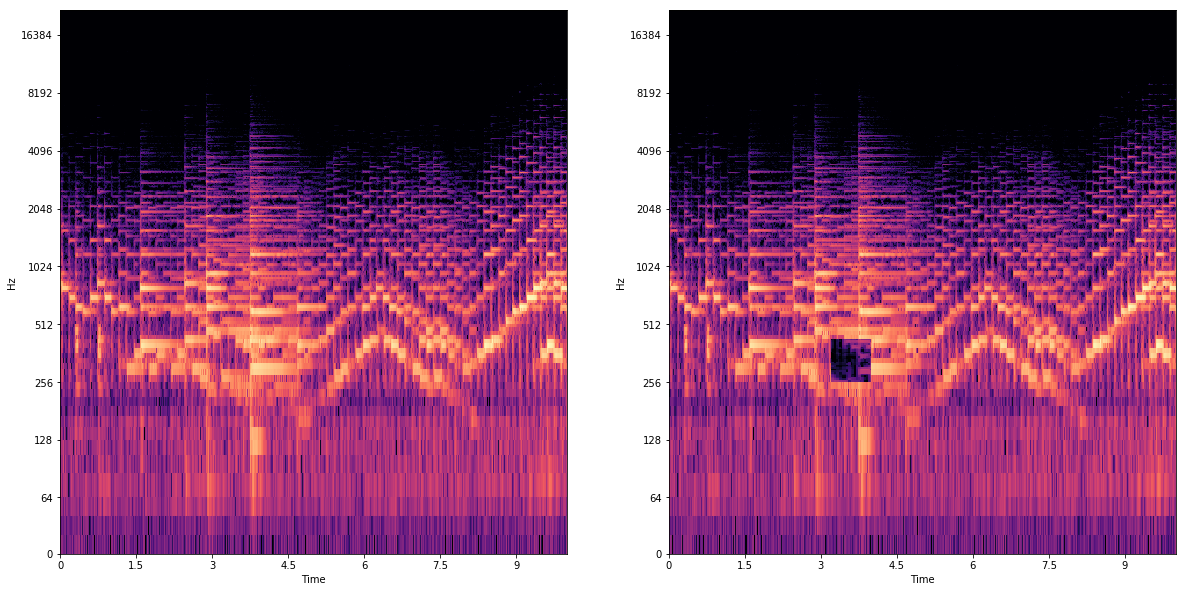

In [38]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)